<a id="l0_8"></a>

<h1 id="1" style="background-color: #fff;font-family:newtimeroman;font-size:150%;color:#6B2B06;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #60a675;">Loading Data</h1>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [16]:
df=pd.read_csv('futuristic_city_traffic copy.csv')

<a id="l1_3"></a>

<h1 id="1" style="background-color: #fff;font-family:newtimeroman;font-size:150%;color:#6B2B06;text-align:center;border-radius:15px 15px;padding:7px;border:solid 3px #B80C09;">1-1 General Information</h1>

In [17]:
df.shape

(370562, 11)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370562 entries, 0 to 370561
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   City                   370562 non-null  object 
 1   Vehicle Type           370562 non-null  object 
 2   Weather                370562 non-null  object 
 3   Economic Condition     370562 non-null  object 
 4   Day Of Week            370562 non-null  object 
 5   Hour Of Day            370561 non-null  float64
 6   Speed                  370561 non-null  float64
 7   Is Peak Hour           370561 non-null  float64
 8   Random Event Occurred  370561 non-null  float64
 9   Energy Consumption     370561 non-null  float64
 10  Traffic Density        370561 non-null  float64
dtypes: float64(6), object(5)
memory usage: 31.1+ MB


In [19]:
df.head()

,City,Vehicle Type,Weather,Economic Condition,Day Of Week,Hour Of Day,Speed,Is Peak Hour,Random Event Occurred,Energy Consumption,Traffic Density
0,SolarisVille,Drone,Snowy,Stable,Sunday,20.0,29.4268,0.0,0.0,14.7134,0.5241
1,AquaCity,Flying Car,Solar Flare,Recession,Wednesday,2.0,118.8000,0.0,0.0,143.5682,0.3208
2,Neuroburg,Autonomous Vehicle,Solar Flare,Recession,Wednesday,16.0,100.3904,0.0,0.0,91.2640,0.0415
3,Ecoopolis,Drone,Clear,Booming,Thursday,8.0,76.8000,1.0,0.0,46.0753,0.1811
4,AquaCity,Autonomous Vehicle,Solar Flare,Stable,Saturday,16.0,45.2176,0.0,0.0,40.1934,0.4544


In [24]:
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 City                     0
Vehicle Type             0
Weather                  0
Economic Condition       0
Day Of Week              0
Hour Of Day              0
Speed                    0
Is Peak Hour             0
Random Event Occurred    0
Energy Consumption       0
Traffic Density          0
dtype: int64


In [23]:
# missing_columns=['Weather','Economic Condition','Day Of Week','Hour Of Day','Speed','Is Peak Hour', 'Random Event Occurred','Energy Consumption','Traffic Density']
# df.dropna(subset=missing_columns,inplace=True)

In [21]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


There isn't any missing value and duplicated data record

# 1. Model Specification

## 1.1. Checking for stationary using Augmented Dickey-Fuller

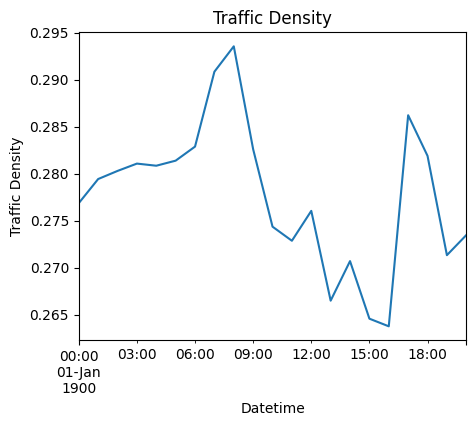

ADF Statistic: -0.21828415608935464
p-value: 0.936306811284775
The series is non-stationary.


In [70]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

df['Datetime'] = pd.to_datetime(
    df['Day Of Week'] + ' ' + df['Hour Of Day'].astype(int).astype(str),
    format='%A %H'
)

df.set_index('Datetime', inplace=True)
traffic_density = df['Traffic Density'].resample('h').mean() #mean of each hour

# Train-test split (90% train, 10% test)
train_size = int(len(traffic_density) * 0.90)
train, test = traffic_density[:train_size], traffic_density[train_size:]

# Step 2: Check for stationarity
def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}") # Augmented Dickey-Fuller
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")

plt.figure(figsize=(5,4))
# plt.plot(train)
train.plot()
plt.title('Traffic Density')
plt.xlabel('Datetime')
plt.ylabel('Traffic Density')
plt.show()

test_stationarity(train)


## 1.2 Defference Transforming

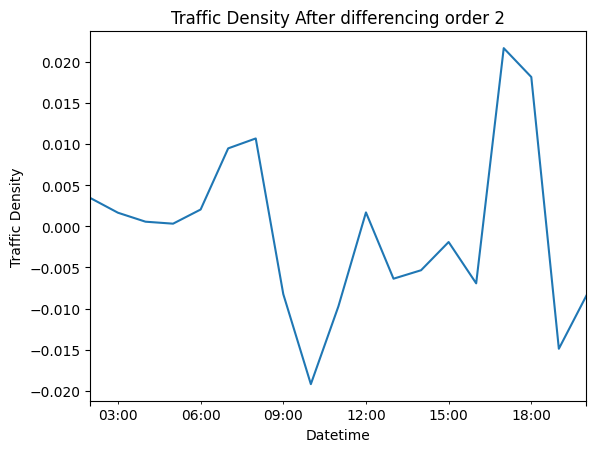

ADF Statistic: -5.696393022147995
p-value: 7.856203557407784e-07
The series is stationary.


In [71]:
# Differencing if needed
train_diff = train.diff(2).dropna()
train_diff.plot()
plt.title('Traffic Density After differencing order 2')
plt.xlabel('Datetime')
plt.ylabel('Traffic Density')
plt.show()

test_stationarity(train_diff)


##### *Note : As our traffic_density is not stationary, we need to do differencing. And we get d=2*

## 1.2. Plot ACF and PACF to find p and q

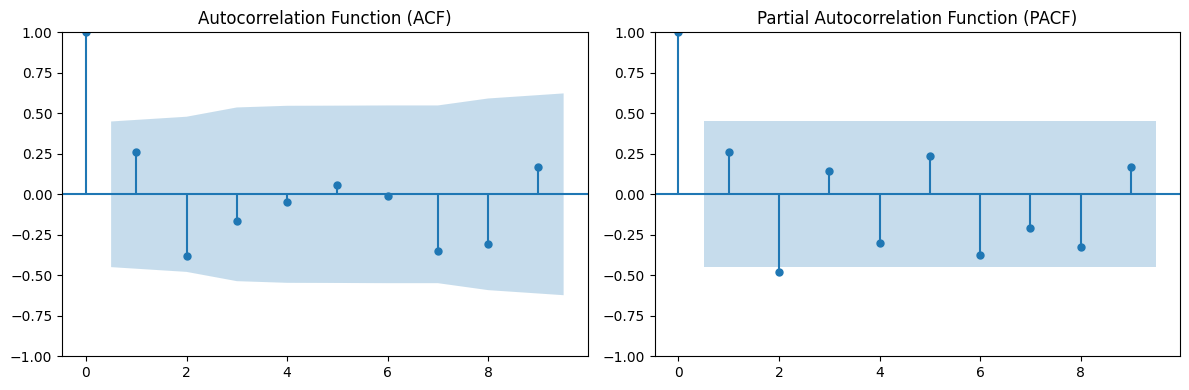

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(train_diff, lags=9, ax=axes[0], alpha=0.05)
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(train_diff, lags=9, ax=axes[1], alpha=0.05)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

* Based on ACF, we decided to choose q=1
* PACF, we choose p=1
### So, we choose **ARIMA(1,2,1)** , p=1, d=2, q=1

# 2. Parameter Estimation

In [97]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(train, order=(1,2,1))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Traffic Density   No. Observations:                   21
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  64.447
Date:                Sun, 19 Jan 2025   AIC                           -122.894
Time:                        16:00:15   BIC                           -120.060
Sample:                    01-01-1900   HQIC                          -122.414
                         - 01-01-1900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0374      0.368     -0.101      0.919      -0.759       0.685
ma.L1         -0.9400      0.670     -1.404      0.160      -2.253       0.373
sigma2      5.954e-05   4.18e-05      1.425      0.1

$ARIMA(1,2,1): \Delta^2Y_t = Y_t-2Y_{t-1}+Y_{t-2}=W_t ; p=1, d=2, q=1$

$W_t=-0.0374W_{t-1}+e_t+0.94e_{t-1}$



where $ \phi = -0.0374$ and $\theta = -0.94$

# 3. Model Diagnostics

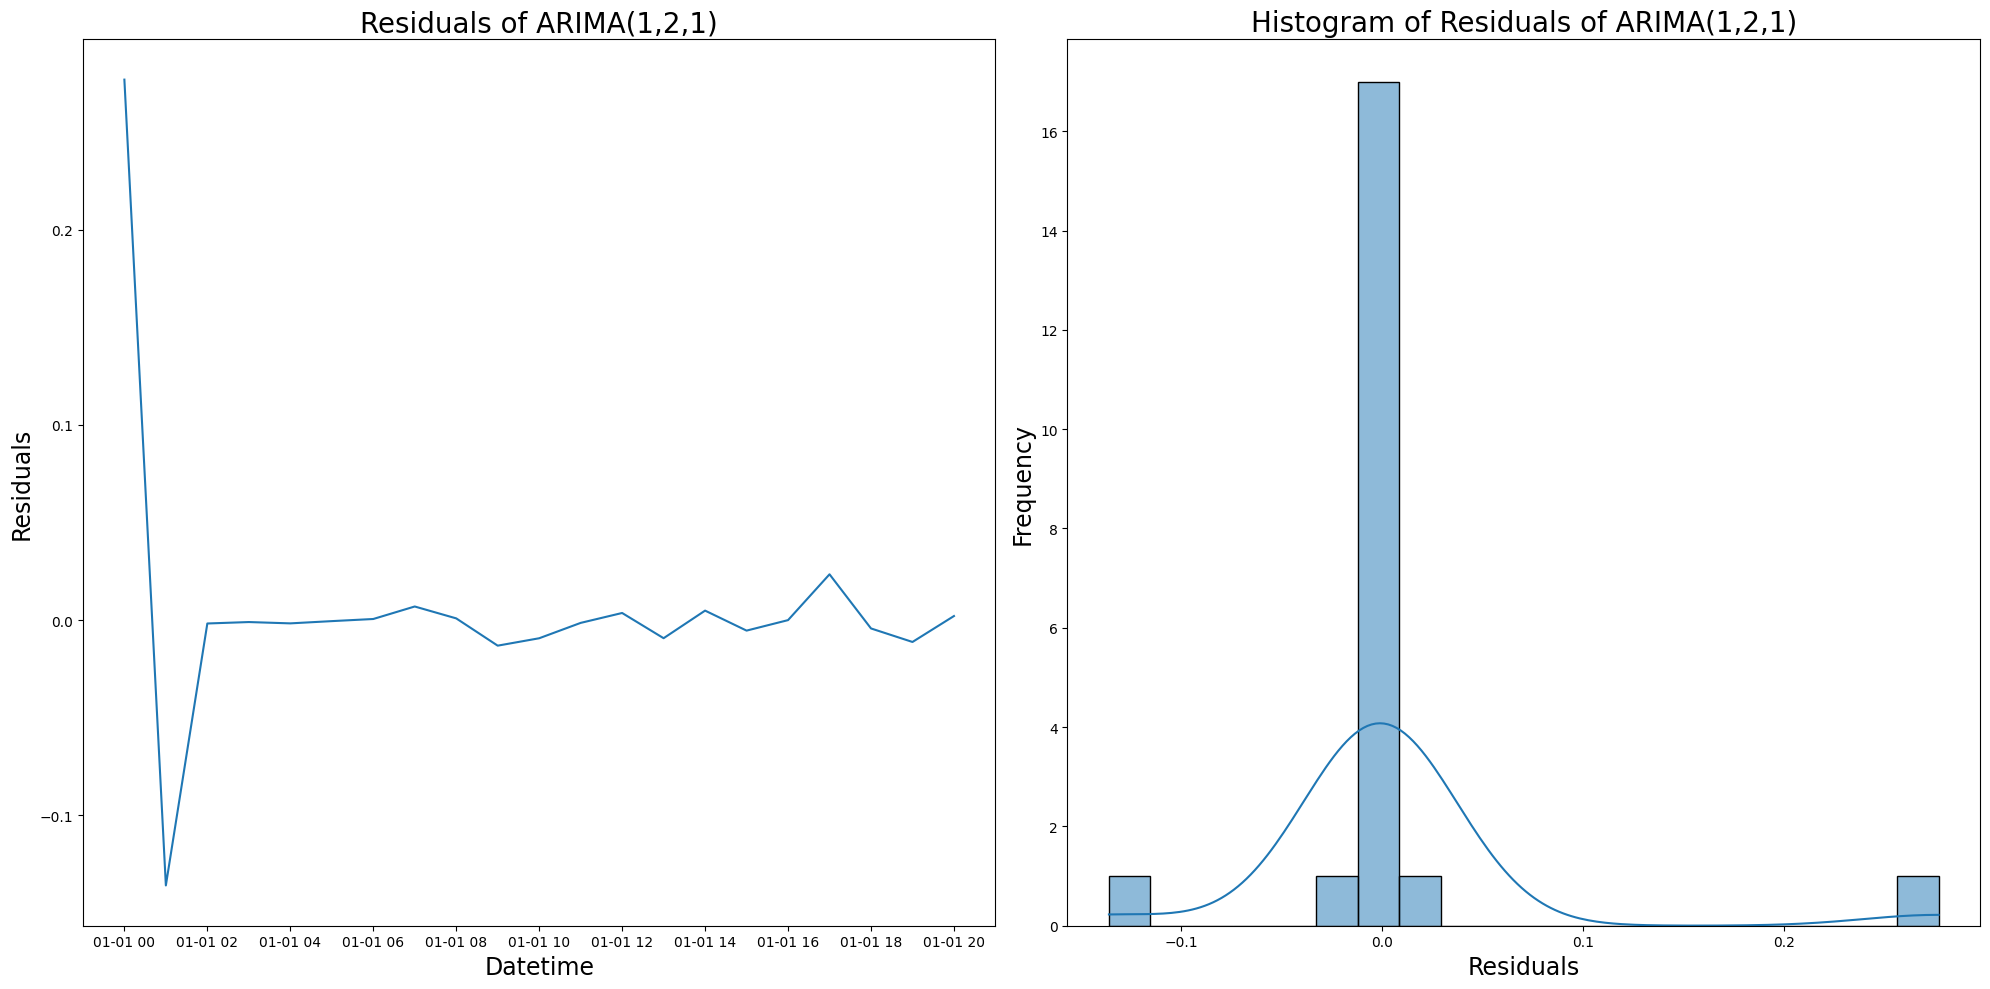

In [98]:
residuals = model_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(residuals)
axes[0].set_title("Residuals of ARIMA(1,2,1)",fontsize=20)
axes[0].set_xlabel("Datetime",fontsize=17)
axes[0].set_ylabel("Residuals",fontsize=17)

sns.histplot(residuals, bins=20, edgecolor='k',ax=axes[1],kde=True)
axes[1].set_title("Histogram of Residuals of ARIMA(1,2,1)",fontsize=20)
axes[1].set_xlabel("Residuals",fontsize=17)
axes[1].set_ylabel("Frequency",fontsize=17)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [99]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")
if p > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

# Ljung-Box test for independence
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)
if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print("Residuals are independent (no autocorrelation).")
else:
    print("Residuals are not independent (autocorrelated).")

Shapiro-Wilk Test Statistic: 0.48803413786846706, p-value: 1.580703316809116e-07
Residuals do not appear to be normally distributed.
    lb_stat  lb_pvalue
10  3.61119   0.963187
Residuals are independent (no autocorrelation).


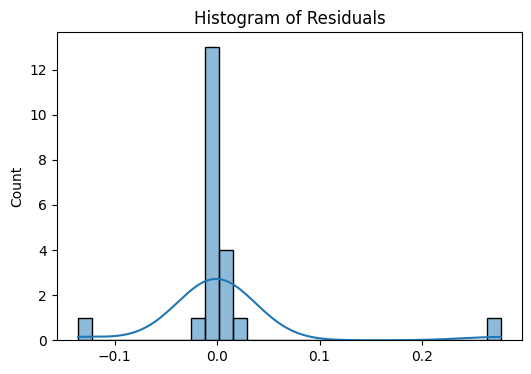

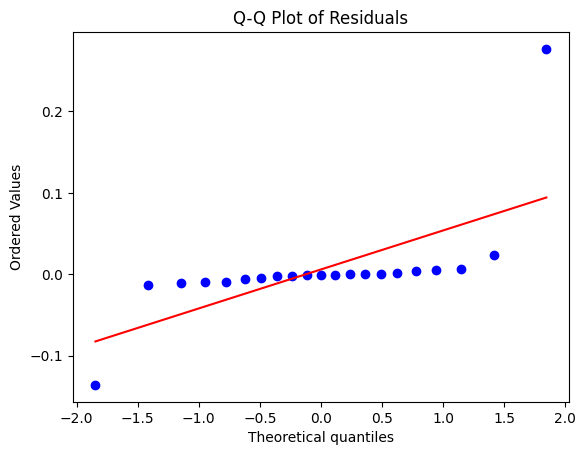

In [100]:
from scipy.stats import probplot

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 4. Forecasting

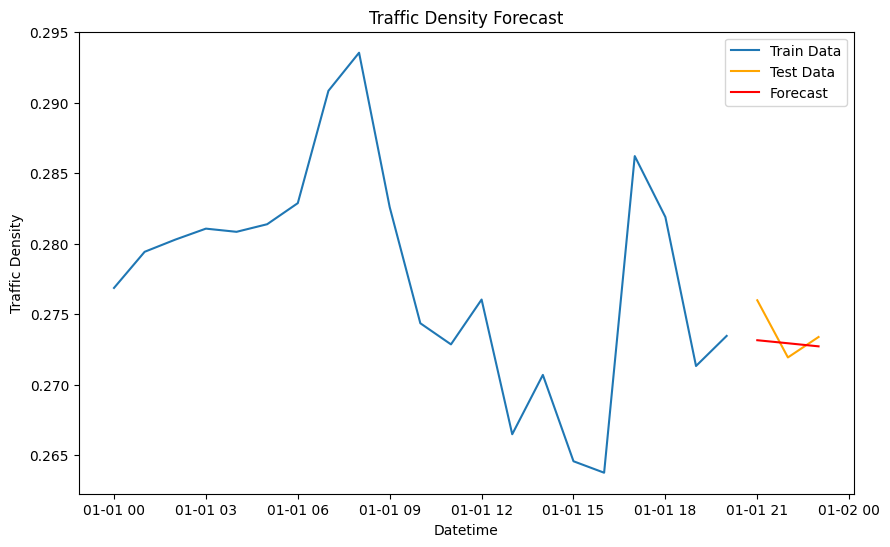

In [101]:
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)
# train_size = int(len(traffic_density) * 0.80)
# train, test = traffic_density[:train_size], traffic_density[train_size:]
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title("Traffic Density Forecast")
plt.xlabel("Datetime")
plt.ylabel("Traffic Density")
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compare forecast to actual values (if within test range)
if len(test) >= forecast_steps:
    actual = test[:forecast_steps]
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-square score: {r2}")
else:
    print("Test data is shorter than the forecast range. Accuracy evaluation skipped.")


Mean Squared Error (MSE): 3.16058425507175e-06
Mean Absolute Error (MAE): 0.0015008706304267723
R-square score: -0.12287425402978958


* MAE = 0.0015: meaning small error
* R-square score = -0.12: negative value reveals that the model is not capturing the overall variance or structure of the data.

# Find p, d and q using auto.arima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7.797, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-134.101, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-134.645, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.44 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-145.739, Time=0.84 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-147.606, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-149.606, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-140.757, Time=0.07 sec
 ARIMA(1,0

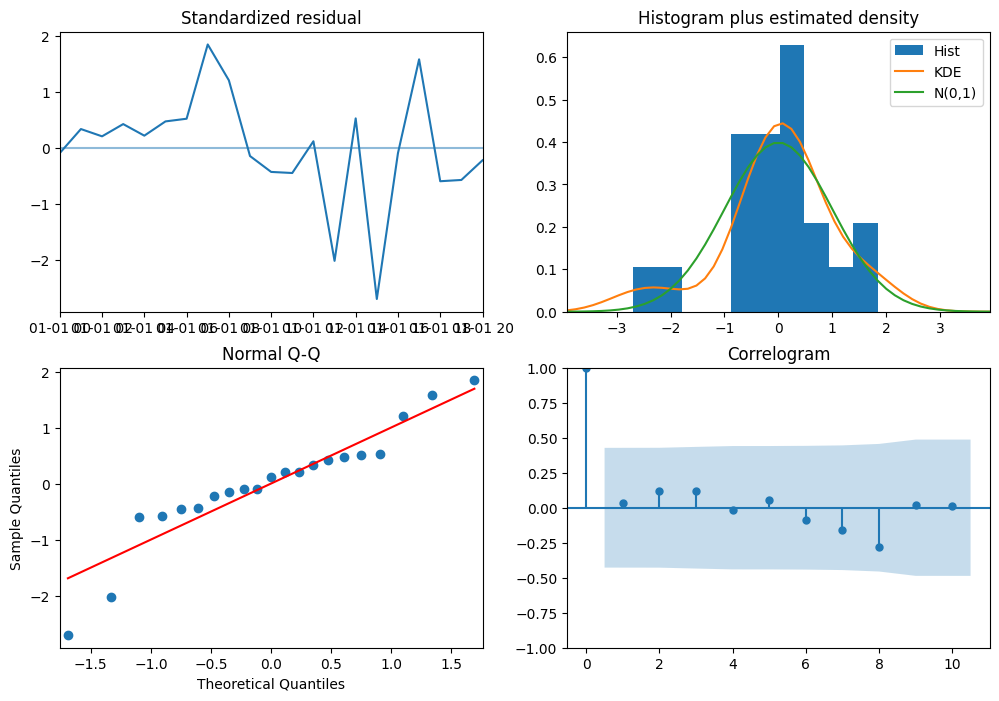

In [103]:
from pmdarima.arima import auto_arima

model = auto_arima(
    train,
    start_p=0, max_p=5,       # Range of AR terms
    start_q=0, max_q=5,       # Range of MA terms
    d=None,                  # Automatically detect differencing
    seasonal=False,           # Assuming no seasonality
    stepwise=True,            # Use stepwise search
    trace=True,               # Show the process
    error_action='ignore',    # Ignore errors for invalid models
    suppress_warnings=True,   # Suppress warnings
    information_criterion='aic',  # Use AIC for model selection
    n_jobs=-1                 # Use all processors for faster execution
)

# Summary of the best model
print(model.summary())

# Plot diagnostics for residual analysis
model.plot_diagnostics(figsize=(12, 8))
plt.show()

# We will do with best model:  ARIMA(0,0,1)(0,0,0) that auto arima recommend

# 2. Parameter estimation

In [104]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(train, order=(0,0,1))
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Traffic Density   No. Observations:                   21
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  77.803
Date:                Sun, 19 Jan 2025   AIC                           -149.606
Time:                        16:03:21   BIC                           -146.472
Sample:                    01-01-1900   HQIC                          -148.926
                         - 01-01-1900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2776      0.003     82.392      0.000       0.271       0.284
ma.L1          0.8526      0.160      5.337      0.000       0.539       1.166
sigma2      3.326e-05   8.86e-06      3.752      0.0

$ARIMA(0,0,1): Y_t=e_t-0.8526e_{t-1} $





where $p=0, d=0, q=1, \theta = 0.8526$

# 3. Model Diagnostics

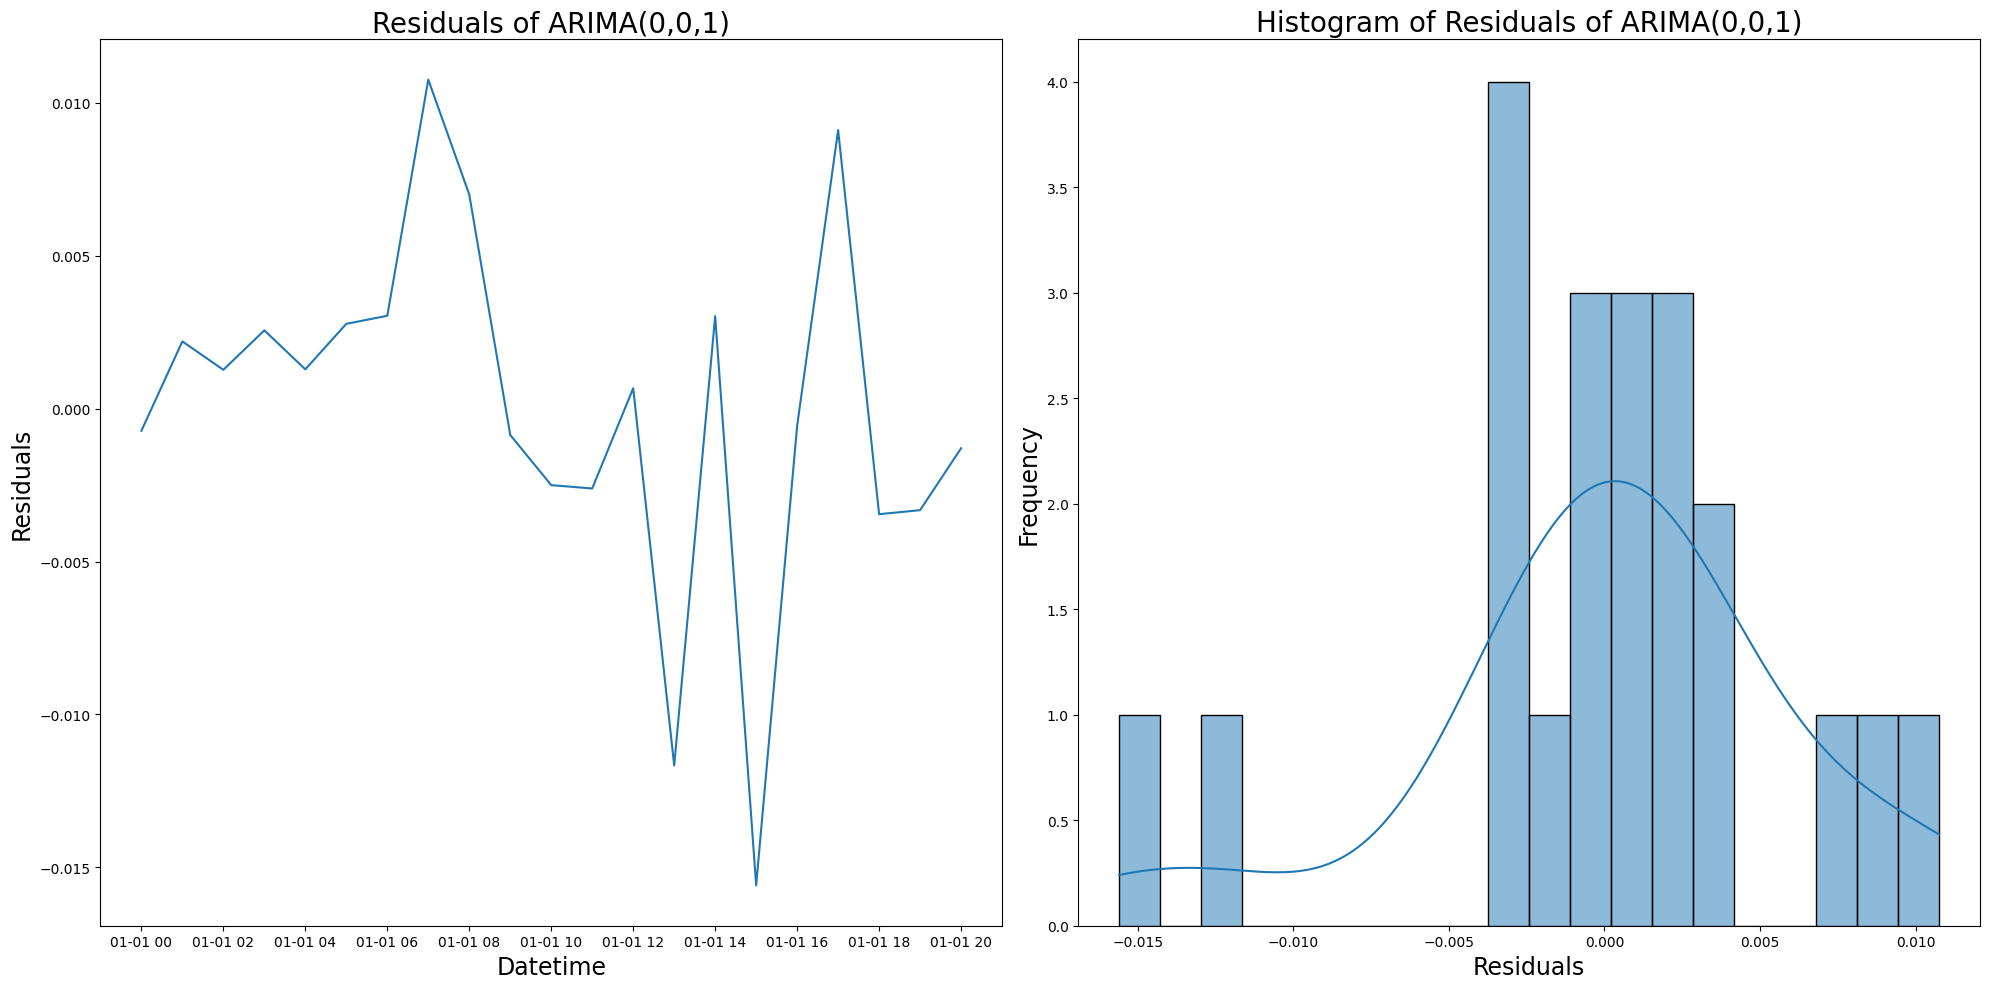

In [106]:
residuals = model_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(residuals)
axes[0].set_title("Residuals of ARIMA(0,0,1)",fontsize=20)
axes[0].set_xlabel("Datetime",fontsize=17)
axes[0].set_ylabel("Residuals",fontsize=17)

sns.histplot(residuals, bins=20, edgecolor='k',ax=axes[1],kde=True)
axes[1].set_title("Histogram of Residuals of ARIMA(0,0,1)",fontsize=20)
axes[1].set_xlabel("Residuals",fontsize=17)
axes[1].set_ylabel("Frequency",fontsize=17)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [108]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p}")
if p > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals do not appear to be normally distributed.")

# Ljung-Box test for independence
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)
if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print("Residuals are independent (no autocorrelation).")
else:
    print("Residuals are not independent (autocorrelated).")

Shapiro-Wilk Test Statistic: 0.9165365355220702, p-value: 0.0740092916366709
Residuals appear to be normally distributed.
     lb_stat  lb_pvalue
10  5.123605   0.882769
Residuals are independent (no autocorrelation).


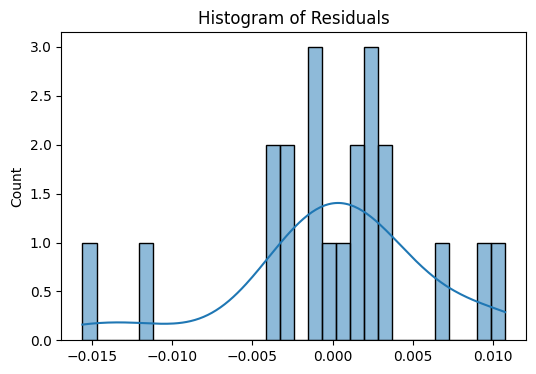

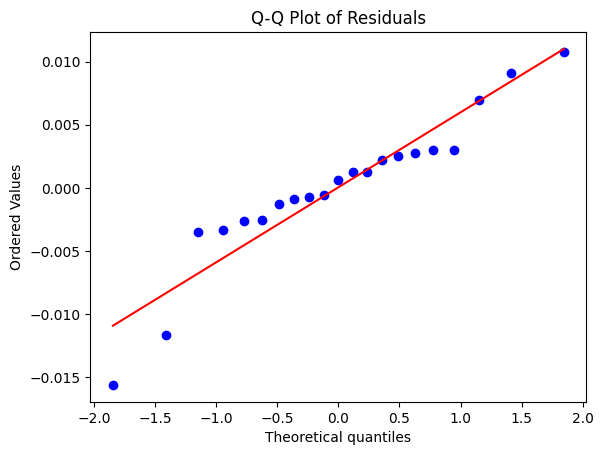

In [109]:
from scipy.stats import probplot

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q Plot
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 4. Forecasting

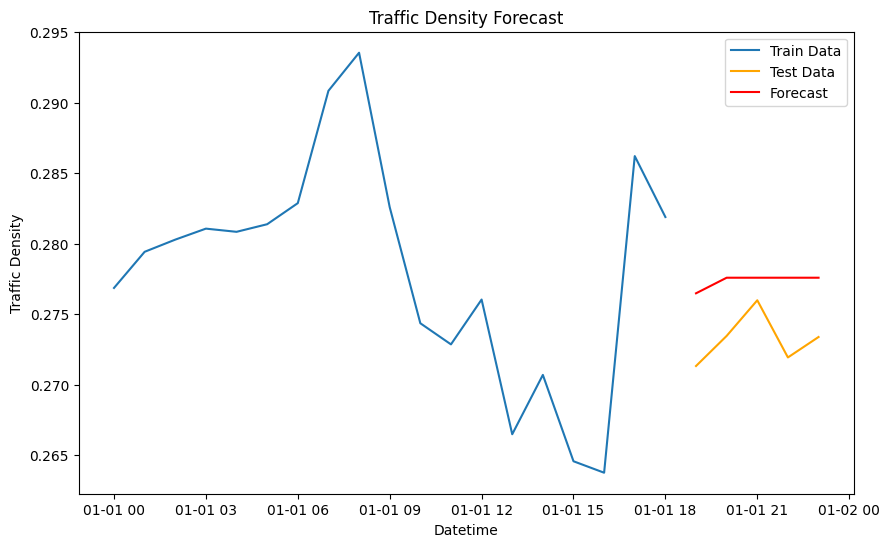

In [110]:
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)
# train_size = int(len(traffic_density) * 0.80)
# train, test = traffic_density[:train_size], traffic_density[train_size:]
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title("Traffic Density Forecast")
plt.xlabel("Datetime")
plt.ylabel("Traffic Density")
plt.legend()
plt.show()

In [111]:
if len(test) >= forecast_steps:
    actual = test[:forecast_steps]
    mse = mean_squared_error(actual, forecast)
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-square score: {r2}")
else:
    print("Test data is shorter than the forecast range. Accuracy evaluation skipped.")


Mean Squared Error (MSE): 1.9169551010150056e-05
Mean Absolute Error (MAE): 0.0041487900678453095
R-square score: -6.377148147051875


# Applied Exponential Smoothing

Exponential Smoothing MAE: 0.0014899102582243324
Exponential Smoothing RMSE: 0.001774945438181403
R-square score: -0.11926717338762227


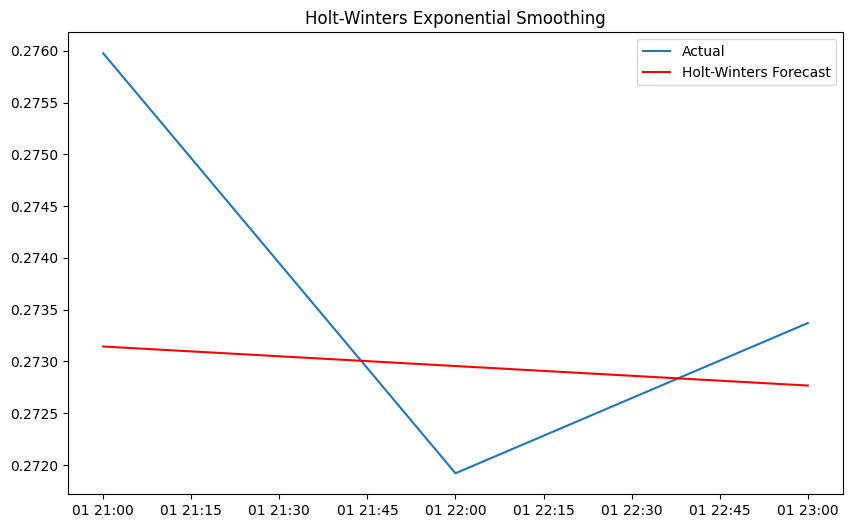

In [114]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train-test split (90% train, 10% test)
train_size = int(len(traffic_density) * 0.90)
train, test = traffic_density[:train_size], traffic_density[train_size:]
hw_model = ExponentialSmoothing(train, trend="add", seasonal=None).fit()

# Forecast
hw_forecast = hw_model.forecast(steps=len(test))

# Evaluate
hw_mae = mean_absolute_error(test, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_r2 = r2_score(test, hw_forecast)

print(f"Exponential Smoothing MAE: {hw_mae}")
print(f"Exponential Smoothing RMSE: {hw_rmse}")
print(f"R-square score: {hw_r2}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast", color="red")
plt.legend()
plt.title("Holt-Winters Exponential Smoothing")
plt.show()
